In [1]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
# import GPy
import matplotlib.ticker as ticker
import gpflow

%matplotlib inline


In [2]:
############################# PARAMETERS ##############################

# dataDir = "./Data/Fixedn/" ## Data folder
# modelDir = "./Models/Fixedn/" ## Data folder
# plotsDir = "./Plots/Fixedn/" ## Data folder

# dataDir = "./Data/Fixedn_val/" ## Data folder
# modelDir = "./Models/Fixedn_val/" ## Data folder
# plotsDir = "./Plots/Fixedn_val/" ## Data folder


dataDir = "./Data/Fixedn_val_latest/" ## Data folder
modelDir = "./Models/Fixedn_val_latest/" ## Data folder
plotsDir = "./Plots/Fixedn_val_latest/" ## Data folder


nRankMax = [2, 4, 5, 6, 7, 8, 12, 16, 32][3]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed
# del_idx = []  ## Random holdouts (not used in training, reserved for validation) 
del_idx = [50, 51, 52, 53, 54]# [8, 12, 3, 43] ## Random holdouts (not used in training, reserved for validation) 
# DONOT use these: (array([22, 15, 19, 20, 35]), array([27, 34, 30, 29, 14])) -- edge cases
snap_ID = 97


############################# PARAMETERS ##############################


fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'
# paramIn = dataDir + 'mg_log_val.design'
paramIn = dataDir + 'mg_log_val_2.design'



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'

GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary

print(GPmodel)
################################# I/O #################################


./Models/Fixedn_val_latest/nCorrLogfixedGP_smooth_rank6snap97


In [3]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]

parameter_array_all = np.loadtxt(paramIn)
parameter_array_all[:, 3] = np.log10(parameter_array_all[:, 3])

In [4]:
parameter_array_all

array([[ 0.14214286,  1.03775513,  0.81836736, -6.36734694,  1.87755203],
       [ 0.15214285,  0.91122443,  0.88367337, -7.10204082,  2.28571606],
       [ 0.15357144,  1.03367341,  0.777551  , -6.6122449 ,  0.81632799],
       [ 0.13499999,  0.89081639,  0.82653058, -4.24489796,  1.06122398],
       [ 0.14071429,  0.95204079,  0.72448981, -4.97959184,  1.22448802],
       [ 0.14928573,  0.96428579,  0.89591837, -4.48979592,  2.04081607],
       [ 0.14571428,  0.92755097,  0.76938778, -7.18367347,  1.63265204],
       [ 0.13857141,  0.97653055,  0.8510204 , -7.26530612,  0.32653081],
       [ 0.12357143,  0.96020401,  0.76530617, -4.32653061,  3.42857194],
       [ 0.15071428,  0.87448984,  0.75714278, -6.93877551,  1.38775599],
       [ 0.13785714,  1.0295918 ,  0.89183676, -5.87755102,  3.34694004],
       [ 0.14642857,  0.9561224 ,  0.81428575, -4.40816327,  0.0816328 ],
       [ 0.14285713,  0.98061216,  0.87142861, -4.16326531,  3.59183598],
       [ 0.14357142,  0.85408169,  0.7

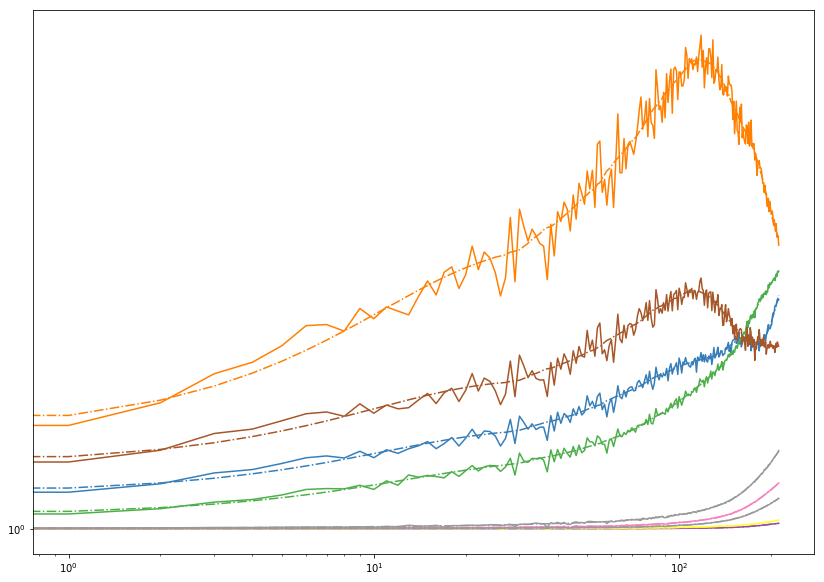

In [5]:
#### adding smoothing filter ########

def SmoothPk(Pk_in):
    Pk_out = scipy.signal.savgol_filter(Pk_in, 51, 3)
    return Pk_out

import scipy.signal
yhat = SmoothPk(PmPl_all[:,:]) # window size 51, polynomial order 3
plt.figure(121, (14,10))

color_id = 0
for galID in [8, 43, 1, 23, 50, 51, 52, 53, 54]:
    color_id = color_id + 1
    plt.plot( np.array(PmPl_all[:,:]).T[:,galID], '-', color=plt.cm.Set1(color_id))
    # y_train = yhat
    plt.plot( np.array(yhat).T[:,galID], '-.', color=plt.cm.Set1(color_id))
plt.xscale('log')
plt.yscale('log')
####################################

In [6]:

############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_log_scaled = lhd
np.savetxt(dataDir+'paralims_nCorr_val_2.txt', np.array([lhdmin, lhdmax]))


############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_log_scaled, del_idx, axis=0)
# PmPl = np.delete(PmPl_all, del_idx, axis=0)
y_train = np.delete(yhat, del_idx, axis=0)

# Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f

In [7]:
print(lhdmin)
print(lhdmax)

[ 0.12  0.85  0.7  -8.    0.  ]
[ 0.155  1.05   0.9   -4.     4.   ]


In [8]:
# np.savetxt(dataDir+'kvals.txt', kvals)

In [9]:
lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims_nCorr_val_2.txt')

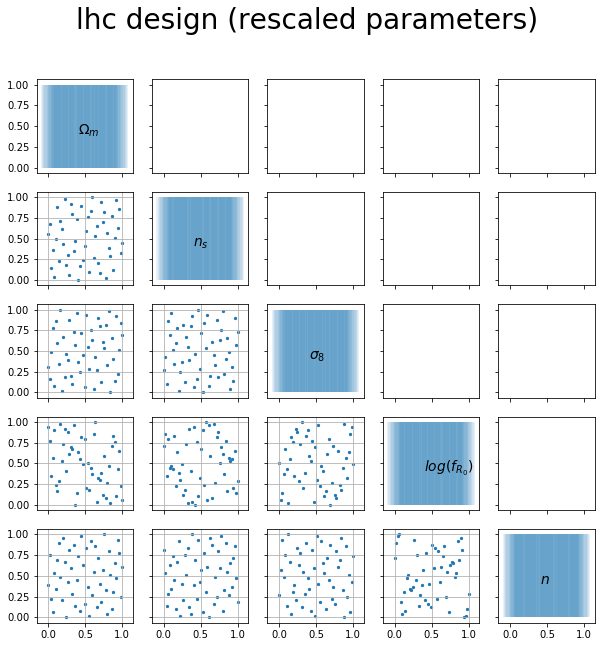

In [10]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$log(f_{R_0})$', r'$n$']


lhd = np.zeros_like(parameter_array)
for i in range(parameter_array.shape[1]):
    _,_,lhd[:, i] = rescale01(parameter_array[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [11]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

# def GPflow_fit(parameter_array, weights, fname= GPmodel):
#     # kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1], ARD=True)
#     # kern = gpflow.kernels.Matern12(input_dim = np.shape(parameter_array)[1], ARD=False)
#     # kern = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
#     # kern1 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)

#     kern1 = gpflow.kernels.Matern12(input_dim = np.shape(parameter_array)[1], ARD=True)
#     kern2 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=False)

#     kern = kern1 + kern2


# #     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
#     m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
# #     print_summary(m)
#     # m.likelihood.variance.assign(0.01)
#     # m.likelihood.variance.assign(1.0)
#     # m.likelihood.variance.assign(5.0)

# ##     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
#     # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])
#     # m.kern.lengthscales.assign(0.5)
    
#     opt = gpflow.train.ScipyOptimizer()
#     opt.minimize(m)
#     m.as_pandas_table()
    
#     from pathlib import Path

#     # print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
#     path = Path(GPmodel)
#     if path.exists():
#         path.unlink()
    
#     saver = gpflow.saver.Saver()
#     saver.save(fname, m)
    



In [12]:
# def GPflow_fit(parameter_array, weights, fname= GPmodel):


#     kern1 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
#     kern2 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=False)

#     kern = kern1 + kern2

#     m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
# #     print_summary(m)
#     m.likelihood.variance.assign(1e-2)
# #     m.kern.lengthscales.assign([100, 100, 100, 100, 100])
# #     m.kern.lengthscales.assign([1, 1, 1, 0.1, 0.1])

# #     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
#     # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])


# #     opt = gpflow.optimizers.Scipy()
    
#     opt = gpflow.train.ScipyOptimizer()
#     opt.minimize(m)
#     m.as_pandas_table()
    
#     from pathlib import Path

#     print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
#     path = Path(GPmodel)
#     if path.exists():
#         path.unlink()
    
#     saver = gpflow.saver.Saver()
#     saver.save(fname, m)

In [13]:
def GPflow_fit(parameter_array, weights, fname= GPmodel):


    kern1 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
    kern2 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=False)

    kern = kern1 + kern2 
    
    #     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
    #     print_summary(m)
    m.likelihood.variance.assign(1e-10)
    # m.likelihood.variance.assign(1.0)

    #     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])
    # m.kern.lengthscales.assign(0.5)
        
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()
        
    from pathlib import Path

    # print(f'GPR lengthscales =', m.kern.lengthscales.value)

        
    path = Path(GPmodel)
    if path.exists():
        path.unlink()
        
    saver = gpflow.saver.Saver()
    saver.save(fname, m)

In [14]:
######################## GP PREDICTION FUNCTIONS ###############################


def GPy_predict(para_array):
    m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def EmuPlusMinus(para_array):
    if len(para_array.shape) == 1:
        W_predArray, W_varArray = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        x_decoded_plus = pca_model.inverse_transform(W_predArray + np.sqrt(W_varArray))
        x_decoded_minus = pca_model.inverse_transform(W_predArray - np.sqrt(W_varArray))
        return np.squeeze(x_decoded), np.squeeze(x_decoded_plus), np.squeeze(x_decoded_minus)


In [15]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=nRankMax)

print('----------------')
print(parameter_array.shape)
print(pca_weights.shape)
print('----------------')

GPflow_fit(parameter_array, pca_weights)

original shape:    (50, 213)
transformed shape: (50, 6)
bases shape: (6, 213)
----------------
(50, 5)
(50, 6)
----------------






INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -114.657834
  Number of iterations: 120
  Number of functions evaluations: 152
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -114.657834
  Number of iterations: 120
  Number of functions evaluations: 152


In [16]:
PmPl_all.max(), PmPl_all.min()

(1.7178153, 0.99927917)

In [17]:
GPmodel

'./Models/Fixedn_val_latest/nCorrLogfixedGP_smooth_rank6snap97'

[0.14, 1.0, 0.7, -5, 1.0]
[0.57142857 0.75       0.         0.75       0.25      ]


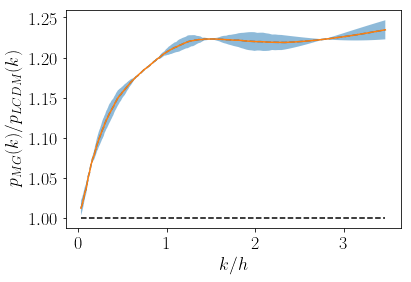

In [31]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))



# params = np.loadtxt(paramIn)
# params.min()
# par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [0.14, 1.0, 0.7, -5, 1.0] #params[11]
# par[3] = np.log10(par[3])
scaled_par = scale01(lhdmin, lhdmax, par)
print(par)
print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)
Emu(scaled_par)
plt.plot(kvals, Emu(scaled_par), '--')
plt.plot(kvals, EmuPlusMinus(scaled_par)[0])
plt.fill_between(kvals, EmuPlusMinus(scaled_par)[1], EmuPlusMinus(scaled_par)[2], alpha = 0.5)
plt.plot(kvals, np.ones_like(kvals), 'k--')

plt.ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
plt.xlabel(r'$k/h$')

plt.show()

In [19]:
# def EmuM(gpmodel, pcamodel, para_array):
#     para_array = np.array(para_array)
#     # print(para_array)
#     para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
#     if len(para_array.shape) == 1:
#         # print(para_array_rescaled)
#         W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
#         x_decoded = pcamodel.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]


# def GPy_predict(para_array):
#     m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
#     W_predArray = m1p[0]
#     W_varArray = m1p[1]
#     return W_predArray, W_varArray


# def Emu(para_array):
#     if len(para_array.shape) == 1:
#         W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
#         x_decoded = pca_model.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]


In [20]:
# m1 = GPmodel
# Emu(np.array(scaled_par))
# EmuM(m1, pca_model, np.array(par))

[0.13333333 0.53333333 0.8        0.33333333 0.        ]
Time per emulation 0.56861  s
[0.46666667 0.86666667 0.66666667 1.         0.53333333]
Time per emulation 0.00367  s
[0.86666667 0.6        0.6        0.46666667 0.8       ]
Time per emulation 0.00364  s
[0.33333333 0.2        0.46666667 0.53333333 0.73333333]
Time per emulation 0.00373  s
[0.26666667 0.66666667 0.53333333 0.4        0.93333333]
Time per emulation 0.00331  s


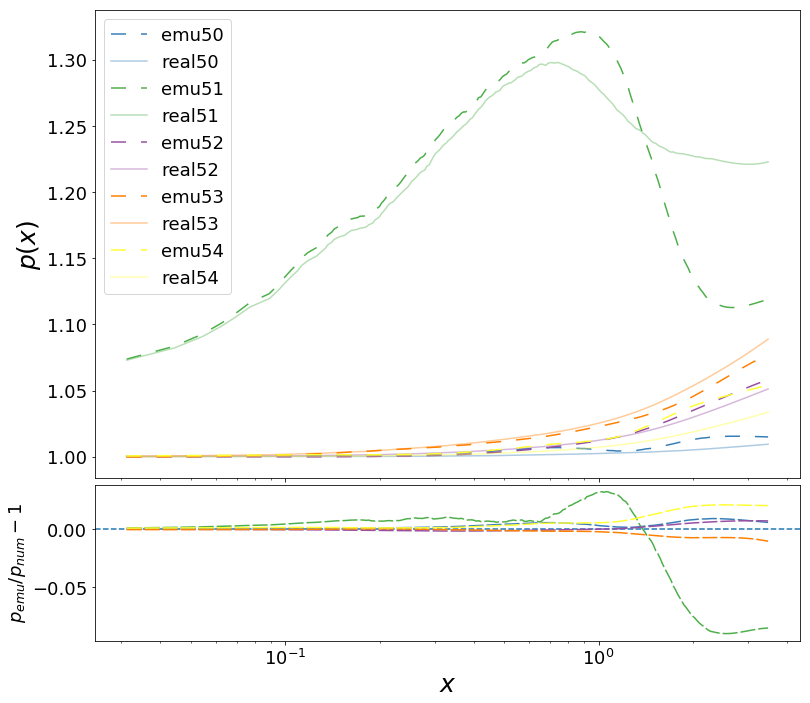

In [21]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))

# plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
del_idx = [50, 51, 52, 53, 54] #[8, 12, 3, 43] #  #[0, 1, 2, 3] 
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_log_scaled[x_id])
    print(parameter_array_log_scaled[x_id])
    # x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)
    
    # ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0])
    # ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu'+str(x_id), dashes=(10, 10), color=plt.cm.Set1(color_id))
    # ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

    # x_test = PmPl_all[x_id]
    x_test = SmoothPk(PmPl_all[x_id])

    ax0.plot(kvals, x_test, alpha=0.4, label='real'+str(x_id), color=plt.cm.Set1(color_id))

    ax1.plot(kvals, (x_decoded_new / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))

ax0.legend()
ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

Time per emulation 0.003  s
Time per emulation 0.004  s
Time per emulation 0.003  s
Time per emulation 0.004  s
Time per emulation 0.003  s


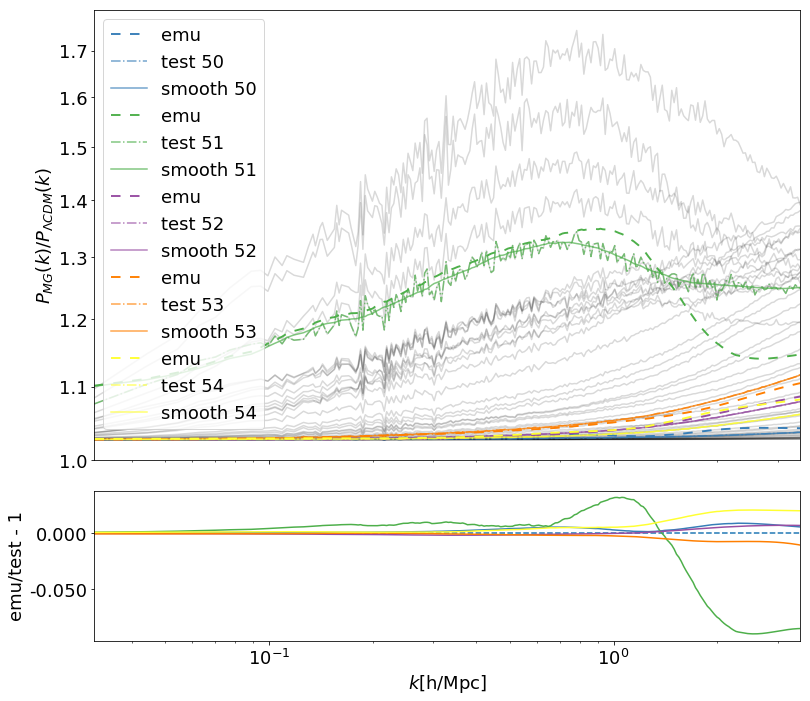

In [22]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
    # ax1.set_ylim(-5e-2, 5e-2)

    ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


    color_id = 0
    for x_id in del_idx:
        color_id = color_id + 1

        time0 = time.time()
        x_decodedGPy = Emu(parameter_array_log_scaled[x_id])  ## input parameters
        time1 = time.time()
        print('Time per emulation %0.3f' % (time1 - time0), ' s')
        x_test = PmPl_all[x_id]
        x_test_smooth = yhat[x_id]
        # x_test_smooth2 = SmoothPk(x_test)

        ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
        ax0.plot(kvals, x_test, alpha=0.7, ls='-.', label='test '+str(x_id), color=plt.cm.Set1(color_id))
        ax0.plot(kvals, x_test_smooth, alpha=0.7, ls='-', label='smooth '+str(x_id), color=plt.cm.Set1(color_id))
        # ax0.plot(kvals, x_test_smooth2, alpha=0.7, ls='--', label='smooth2 '+str(x_id), color=plt.cm.Set1(color_id))

        # ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))
        ax1.plot( kvals, (x_decodedGPy[:]) / (x_test_smooth)  - 1, color=plt.cm.Set1(color_id))

# ax0.text(0.07, 1.4, 'z = %0.2f'%z_ID, fontsize= 18, style='italic')

ax0.legend()
plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

Time per emulation 0.67557  s
Time per emulation 0.02022  s
Time per emulation 0.01661  s
Time per emulation 0.01576  s
Time per emulation 0.01858  s


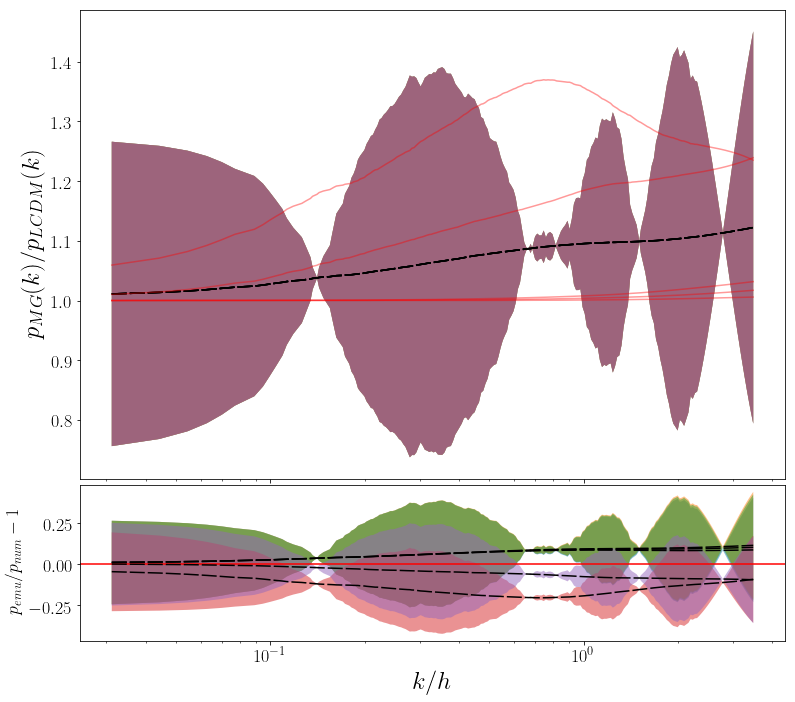

In [23]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, color = 'r')

color_id = 0
del_idx = [0, 1, 2, 3, 4] #[8, 12, 3, 43]
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
    x_decoded_new = Emu(parameter_array_all[x_id])
    x_decoded_smooth = SmoothPk(x_decoded_new )
    
    ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0], ls='--', dashes=(10, 2), color='k')
    ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    # ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', color = 'k', label='emu', dashes=(10, 10))
    # ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', color = 'r', label='emu', dashes=(10, 10))

#     x_test = PmPl_all[x_id]
    x_test = SmoothPk(PmPl_all[x_id])

    # ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_test, alpha=0.4, label='real', color='red')

    ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color='k')
    ax1.fill_between(kvals, (EmuPlusMinus(parameter_array_all[x_id])[1]/ (x_test) ) - 1, (EmuPlusMinus(parameter_array_all[x_id])[2]/ (x_test) ) - 1, alpha = 0.5)


ax0.set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax1.set_xlabel(r'$k/h$')

ax0.set_xticklabels([])
plt.savefig(plotsDir + 'uq_Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [24]:
# params = np.loadtxt(paramIn)
# params.min()

In [25]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)
par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [1.40000015e-01, 1.00918353e+00, 7.73469388e-01, 1.13183784e-06, 1.093877602e+00] #params[11]

scaled_par = scale01(lhdmin, lhdmax, par)
print(par)
print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)
Emu(scaled_par)
plt.plot(kvals, Emu(scaled_par))
plt.plot(kvals, np.ones_like(kvals), 'k--')
plt.show()

NameError: name 'params' is not defined

sample emulated value: [1.04766008 1.05368114 1.0593074  1.06455313 1.0694326  1.07396011
 1.07814993 1.08201635 1.08557365 1.0888361  1.09181799 1.0945336
 1.09699721 1.09922311 1.10122557 1.10301888 1.10461732 1.10603516
 1.1072867  1.10838621 1.10934797 1.11018627 1.11091538 1.11154959
 1.11210318 1.11259043 1.11262737 1.11272367 1.11400049 1.11374144
 1.11392258 1.11517859 1.11667478 1.11834899 1.11934824 1.1207394
 1.12254045 1.12337022 1.12322814 1.12480858 1.12605879 1.12689975
 1.1283871  1.12983354 1.13140587 1.13271958 1.13425245 1.13591143
 1.13708537 1.13811279 1.13862018 1.13958739 1.1399846  1.14098168
 1.14333575 1.14379891 1.14577432 1.14692606 1.14893072 1.1498947
 1.15119651 1.15269189 1.15455992 1.15567968 1.15671064 1.15811134
 1.15875901 1.1598286  1.16143162 1.16232819 1.16395426 1.16463649
 1.16459714 1.16625132 1.16836834 1.16955888 1.1711254  1.17226234
 1.17470253 1.17532455 1.17732941 1.17935654 1.18129526 1.18209227
 1.18262823 1.18403274 1.18518494 1.186071

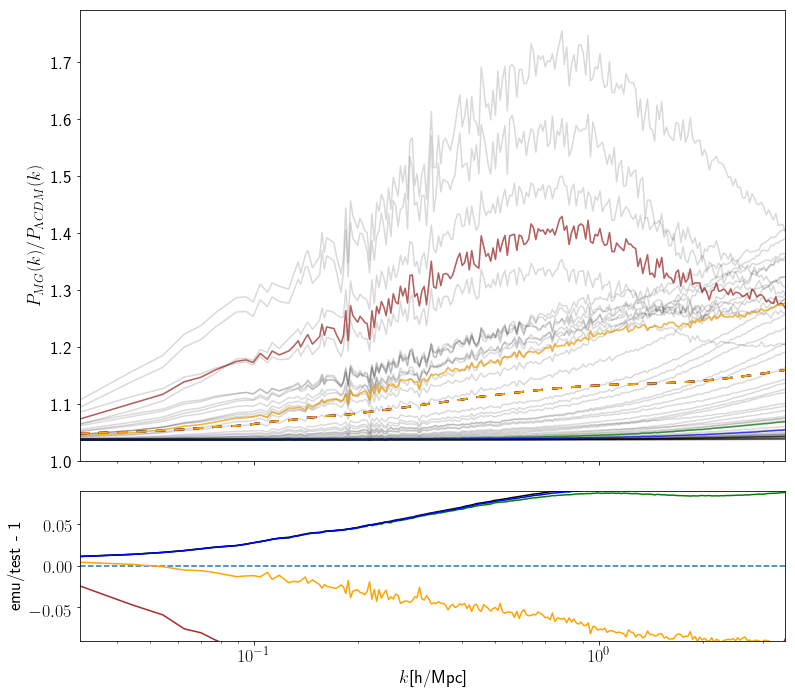

In [26]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

## Both models below have to be loaded -- one for GP and one for PCA
# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model' + str(nRankMax) + '.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

pca_model = pickle.load(open(PCAmodel , 'rb'))


## Calling the Emulator function with 5 arguements [Om, ns, sigma8, fR0, n]

print('sample emulated value:', Emu(np.array([1, 1, 1, 1, 1]) ) )
print(50*'=')

#########################################################

colorList = ['r', 'g', 'k', 'b', 'brown', 'orange', 'purple', 'darkslateblue', 'darkkhaki']

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually


plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
ax1.set_xlabel(r'$k$[h/Mpc]')
ax1.axhline(y=0, ls='dashed')

# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'emu/test - 1')

ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')


ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])
ax1.set_ylim(-9e-2, 9e-2)

# del_idx = [0, 1, 2, 5, 6, 7, 8]
color_id = 0
for x_id in del_idx:
    print(x_id)
    color_id = color_id + 1
    time0 = time.time()
    x_decodedGPy = Emu(parameter_array_all[x_id])  ## input parameters
    time1 = time.time()
    print('Time per emulation %0.4f' % (time1 - time0), ' s')
    x_test = PmPl_all[x_id]

    ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=colorList[color_id])
    ax0.plot(kvals, x_test, alpha=0.7, label='test', color=colorList[color_id])
    ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=colorList[color_id])
    
start, end = ax0.get_ylim()
ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'MGemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()



In [27]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


In [28]:
# pca_recon1 = np.matmul(pca_weights, pca_bases)
# pca_recon = pca_model.inverse_transform(pca_weights)
# W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))

test_idx = [51, 54]
for x_id in test_idx:
#     x_pca_recon = np.matmul(pca_weights, pca_bases)
    para_array = parameter_array_all[x_id]
    W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
    
#     x_emu_recon = pca_model.inverse_transform(W_predArray)
    x_pca_recon = pca_model.inverse_transform(pca_weights)

    x_test = PmPl_all[x_id]
    
#     plt.plot(kvals, (x_emu_recon[0]) / (x_test) - 1, ls=':', color=plt.cm.Set1(color_id))
    plt.plot(kvals, (x_pca_recon[x_id]) / (x_test) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))

#     plt.plot(kvals, (x_test) , ls='-', color=plt.cm.Set1(color_id))
#     plt.plot(kvals, x_pca_recon[x_id], ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))
#     plt.scatter((W_predArray[0]), pca_weights[x_id])

plt.show()


IndexError: index 51 is out of bounds for axis 0 with size 50

[0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1.]
[0.49999998 0.49999997 0.49999993 0.5        0.50000002]
0
1
2
3
4


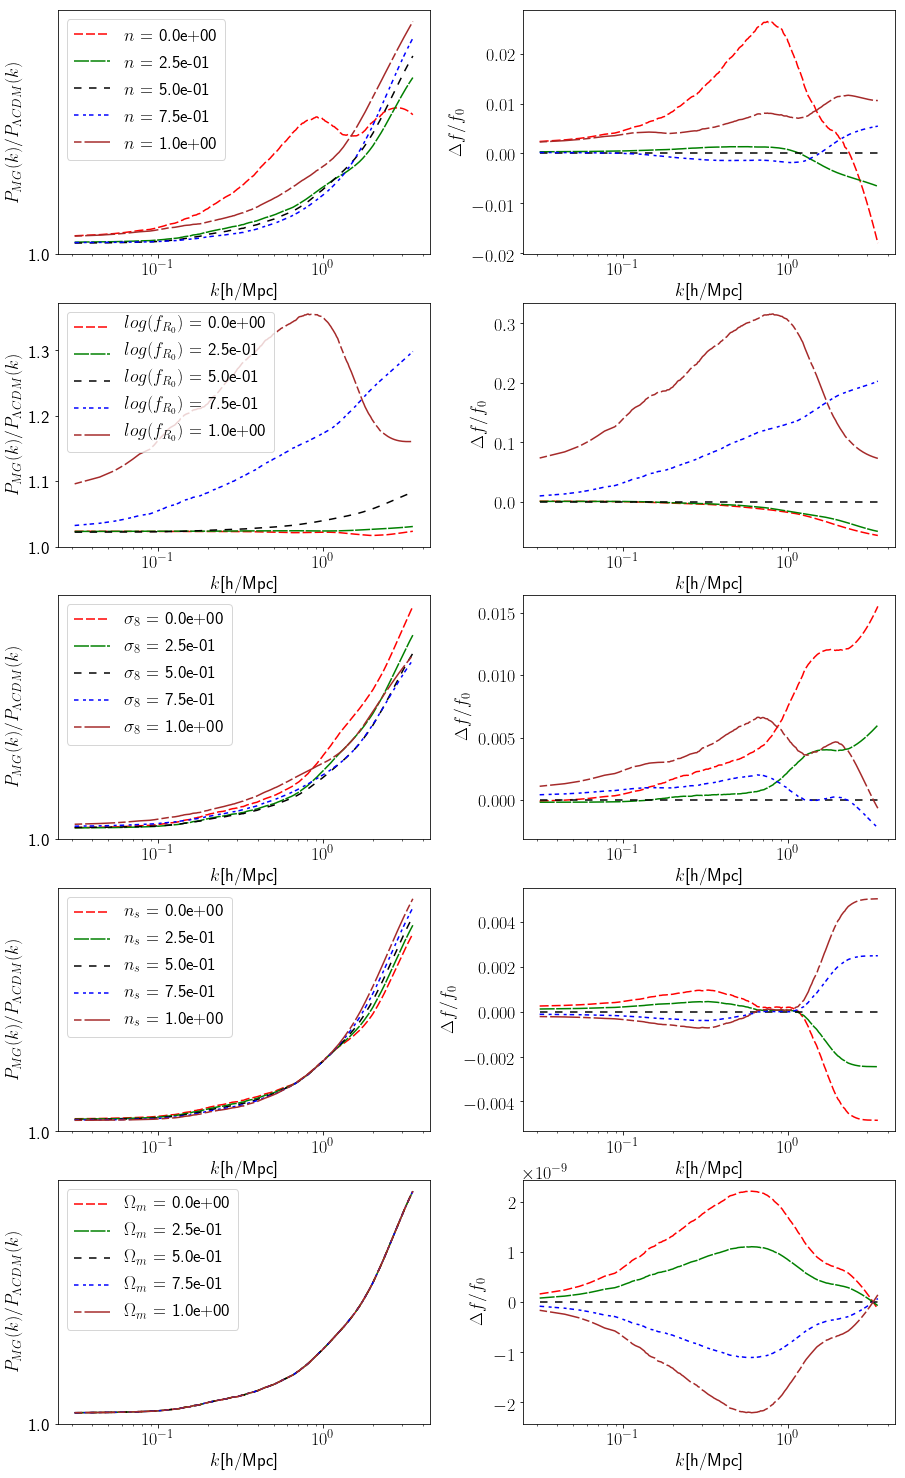

In [29]:
from itertools import cycle
import matplotlib.ticker as ticker

allMax = np.max(parameter_array, axis = 0)
allMin = np.min(parameter_array, axis = 0)
allMean = np.mean(parameter_array, axis = 0)

#allMean = 0.5*(allMax - allMin)

print(allMin)
print(allMax)
print(allMean)
Pk_mean = Emu(allMean) 


PlotCls = True

numPlots = 5

fig, ax = plt.subplots(5,2, figsize = (15,26))
# fig = plt.figure()
# fig.add_subplot(221)   #top left
# fig.add_subplot(222)   #top right
# fig.add_subplot(223)   #bottom left
# fig.add_subplot(224)   #bottom right
# plt.show()
plt.subplots_adjust(wspace=0.25)

if PlotCls:
    for paramNo in range(5):
        print(paramNo)
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        #plt.figure(32)
        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!
            x_decodedGPy = Emu(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])
            #ax[paramNo,0].set_ylim(9.9, None)
            #ax[4-paramNo,0].set_yscale('log')
            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            #ticks = np.linspace(np.min(10**x_decodedGPy), np.max(10**x_decodedGPy), 5)
            #ticks = np.array([10, 15, 20, 25, 30, 35, 40])
            #ax[4-paramNo,0].set_yticks(ticks, minor = True)
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            #ax[paramNo,1].set_yscale('log')
            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')
            #ax[paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity_snap" + str(snap_ID) + ".png",  bbox_inches="tight", dpi=200)

plt.show()




In [30]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure
output_notebook()

x = kvals
y = Emu(parameter_array_all[x_id])#/(Pk_mean) - 1 


# p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, y_range=(1,1.8), background_fill_color='white')
p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, background_fill_color='white')

r = p.line(x, y, color='black', line_width=1.5, alpha=0.8)

p1min, p2min, p3min, p4min, p5min = parameter_array_all.min(axis = 0)
p1max, p2max, p3max, p4max, p5max = parameter_array_all.max(axis = 0)
p1mean, p2mean, p3mean, p4mean, p5mean = parameter_array_all.mean(axis = 0)

def update(p1=p1mean , p2= p2mean, p3=p3mean, p4=p4mean, p5=p5mean):
#     if   f == "sin": func = np.sin
#     elif f == "cos": func = np.cos
    r.data_source.data['y'] = Emu(np.array([p1, p2, p3, p4, p5]))#/Pk_mean - 1
    push_notebook()
    
    

show(p, notebook_handle=True)


interact(update, p1=(p1min,p1max), p2=(p2min,p2max), p3=(p3min, p3max), p4 = (p4min, p4max), p5 = (p5min, p5max))

# output_file( modelDir + "emu.html")


<function __main__.update(p1=0.13722424191515148, p2=0.9513333275878789, p3=0.802060593678788, p4=-5.983030303030304, p5=2.0363636960981824)>